# 1, Import Dataset

In [7]:
leo040802_ktvic_dataset_path = '/kaggle/input/ktvic-dataset'
print('Data source import complete.')

Data source import complete.


# 2, Import Libraries & Set Up Configuration

In [8]:
# Import libraries
import torch
import os
import json
import itertools
import nltk
import numpy as np
from PIL import Image
from itertools import count
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [9]:
# Download necessary NLTK data
nltk.download('punkt', quiet=True)

True

In [10]:
# Hyperparams
train_img_folder = os.path.join(leo040802_ktvic_dataset_path, 'ktvic_dataset/train-images')
test_img_folder = os.path.join(leo040802_ktvic_dataset_path, 'ktvic_dataset/public-test-images')
train_json_path = os.path.join(leo040802_ktvic_dataset_path, 'ktvic_dataset/train_data.json')
test_json_path = os.path.join(leo040802_ktvic_dataset_path, 'ktvic_dataset/test_data.json')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 16
NUM_EPOCHS = 20
LR = 0.001
NUMS_LAYER = 1
EMBED_SIZE = 256
HIDDEN_SIZE = 512

In [11]:
# with open(train_json_path, "r") as f:
#     json_data = json.load(f)
# print(json_data)

# 3, Vocab

In [12]:
class Vocab:
    def __init__(self, texts):
        words = list(itertools.chain(*[text.split(" ") for text in texts]))
        counter = Counter(words)
        special_tokens = ["<BOS>", "<EOS>", "<PAD>", "<UNK>"]

        self.word2idx = {key: i for i, key in zip(count(start=4), counter.keys())}
        self.word2idx.update({key: i for i, key in enumerate(special_tokens)})
        self.idx2word = {i: key for key, i in self.word2idx.items()}
        self.max_seq_len = 256

    def __len__(self):
        return len(self.word2idx)

    def get_word2idx(self):
        return self.word2idx

    def get_idx2word(self):
        return self.idx2word

# 4, Dataset

In [13]:
class KTVICDataset(Dataset):
    def __init__(self, json_data_path, imgs_folder_path, caps_per_img=5):
        with open(json_data_path, "r") as f:
            json_data = json.load(f)
        imgs_path = json_data["images"]
        labels_path = json_data["annotations"]
        f.close()

        self.imgs_folder_path = imgs_folder_path
        self.vocab = Vocab(texts=[item["segment_caption"] for item in labels_path])

        self.data = []
        for img_item in imgs_path:
            img_path = os.path.join(imgs_folder_path, img_item["filename"])
            img_id = img_item["id"]

            label_count = 0
            labels = []
            for label_item in labels_path:
                if label_item["image_id"] == img_id:
                    label = label_item["segment_caption"]
                    labels.append(label)
                    label_count += 1
                if label_count == caps_per_img:
                    break
            self.data.extend([(img_path, label) for label in labels])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(os.path.join(self.imgs_folder_path, img_path)).convert("RGB")
        return img, label


# 5, Collator

In [14]:
class Collator:
    def __init__(self, vocab, model='resnet101') -> None:
        self.vocab = vocab
        self.bos_id = self.vocab.get_word2idx()["<BOS>"]
        self.eos_id = self.vocab.get_word2idx()["<EOS>"]
        self.pad_id = self.vocab.get_word2idx()["<PAD>"]
        self.model = model

    def tokenize_texts(self, captions):
        tokenize_captions = [caption.split(" ") for caption in captions]
        truncated_captions = [caption[:self.vocab.max_seq_len] for caption in tokenize_captions]
        max_caption_len = max([len(caption) for caption in truncated_captions])

        padded_captions = []
        for caption in truncated_captions:
            c = [self.vocab.get_word2idx()[word] for word in caption]
            seq = [self.bos_id] + c + [self.eos_id] + [self.pad_id] * (max_caption_len - len(c))
            padded_captions.append(torch.tensor(seq))

        padded_captions = [torch.Tensor(seq).long() for seq in padded_captions]
        return pad_sequence(padded_captions, batch_first=True)

    def transform_img(self, images):
        if self.model == 'resnet101':
            img_tensors = []
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
            for img in images:
                img_tensor = transform(img)
                img_tensors.append(img_tensor)
            return torch.stack(img_tensors)
        else:
            pass

    def __call__(self, batch):
        images = [item[0] for item in batch]
        captions = [item[1] for item in batch]
        images = self.transform_img(images)
        captions = self.tokenize_texts(captions)
        return {"images": images, "captions": captions}

# 6, Visualize

In [15]:
def visualize_img(img_obj, og_caption, gen_caption):
    plt.imshow(img_obj)
    plt.title(f"Original Caption: {og_caption}\nGenerated Caption: {gen_caption}")
    plt.show()

# 7, Model

In [16]:
class ResnetToLSTM(nn.Module):
    def __init__(self, embed_size, vocab, hidden_size, num_layer, device='cuda'):
        super(ResnetToLSTM, self).__init__()

        # Initialize vocab
        self.vocab = vocab
        vocab_size = len(vocab)

        # Initialize resnet
        resnet_encoder = models.resnet101(pretrained=True).to(device)

        # Remove the last layer of resnet
        features = list(resnet_encoder.children())[:-1]
        feature_size = 2048
        self.resnet = nn.Sequential(*features)

        # Freeze the params of the model
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.embed = nn.Embedding(vocab_size, embed_size).to(device)
        self.lstm = nn.LSTM(embed_size + feature_size, hidden_size, num_layers=num_layer, batch_first=True).to(device)
        self.linear = nn.Linear(hidden_size, vocab_size).to(device)

    def forward(self, images, captions):
        features = self.resnet(images)
        captions = captions[:, :-1]
        embeddings = self.embed(captions)
        features = features.squeeze().unsqueeze(1).repeat(1, embeddings.size(1), 1)
        embeddings = torch.cat((features, embeddings), 2)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

    def generate_caption(self, image, max_length=30):
        # Process image if it's a PIL Image
        if not torch.is_tensor(image):
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
            image = transform(image).unsqueeze(0).to(self.device)

        # Extract image features
        with torch.no_grad():
            features = self.resnet(image)
            features = features.squeeze().unsqueeze(0)

        # Initialize caption generation
        word_idx = torch.tensor([self.vocab.get_word2idx()["<BOS>"]]).to(self.device)
        embeddings = self.embed(word_idx).unsqueeze(1)

        # Initialize hidden and cell states
        hidden = None

        # Generated caption indices
        sampled_ids = []

        # Generate the caption word by word
        for i in range(max_length):
            # Prepare the input for this timestep
            feature_input = features.unsqueeze(1)
            inputs = torch.cat((feature_input, embeddings), 2)

            # Forward through LSTM
            outputs, hidden = self.lstm(inputs, hidden)

            # Predict the next word
            outputs = self.linear(outputs.squeeze(1))
            _, predicted = outputs.max(1)

            # Add the predicted word to the sequence
            sampled_ids.append(predicted.item())

            # If end token is predicted, stop generating
            if predicted.item() == self.vocab.get_word2idx()["<EOS>"]:
                break

            # Update input for next timestep
            embeddings = self.embed(predicted).unsqueeze(1)

        # Convert indices to words
        sampled_ids = sampled_ids[:-1] if sampled_ids[-1] == self.vocab.get_word2idx()["<EOS>"] else sampled_ids
        words = [self.vocab.get_idx2word()[idx] for idx in sampled_ids]

        # Join words to form caption
        caption = " ".join(words)

        return caption

# 8, Train

In [17]:
# Initialize dataset & dataloader
train_dataset = KTVICDataset(json_data_path=train_json_path, imgs_folder_path=train_img_folder)
test_dataset = KTVICDataset(json_data_path=test_json_path, imgs_folder_path=test_img_folder)
vocab = train_dataset.vocab

collator = Collator(vocab=vocab)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collator)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collator)

In [18]:
# Initialize model
model = ResnetToLSTM(
    embed_size=EMBED_SIZE,
    vocab=vocab,
    hidden_size=HIDDEN_SIZE,
    num_layer=NUMS_LAYER,
    device=device
)

# Initialize loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 196MB/s]  


In [ ]:
# Training loop
total_loss = 0
step_count = 0

for epoch in range(NUM_EPOCHS):
    # Wrap the dataloader with tqdm for epoch progress
    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}', leave=True)

    for i, batch in enumerate(train_loop):
        images = batch["images"].to(device)
        captions = batch["captions"].to(device)

        # Forward pass
        outputs = model(images, captions)
        loss = criterion(outputs.permute(0, 2, 1), captions[:, 1:])

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss values
        batch_loss = loss.item()

        # Update progress bar with current loss
        train_loop.set_postfix(loss=batch_loss)

In [ ]:
torch.save(model.state_dict(), 'ResnetToLSTM.pth')

# 9, Inference

In [19]:
# Load checkpoint
model.load_state_dict(torch.load("/kaggle/input/vietimagecaptioningdataset/ResnetToLSTM.pth", map_location=torch.device(device), weights_only=True))
model.device = device

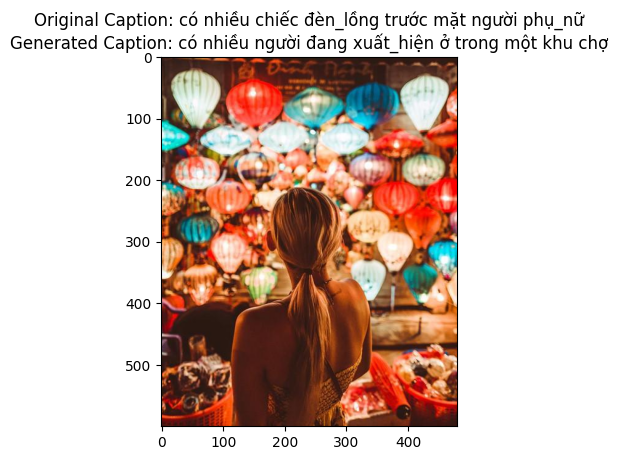

In [30]:
model.eval() 

# Load example
example = train_dataset[16]

# Extract image, og caption & generate caption
gen_cap = model.generate_caption(image=example[0])
og_cap = example[1]
image = example[0]

# Visualize
visualize_img(
    img_obj=image, 
    og_caption=og_cap, 
    gen_caption=gen_cap
)